[![Binder][binder-badge]][binder-url]

[![Google Colab][colab-badge]][colab-url]

[![Deepnote][deepnote-badge]][deepnote-url]

[binder-badge]: https://mybinder.org/badge.svg
[binder-url]: https://mybinder.org/v2/gh/farhanreynaldo/side-project/master?filepath=bayesian-review.ipynb/master
[colab-badge]: https://colab.research.google.com/assets/colab-badge.svg
[colab-url]: https://colab.research.google.com/github/farhanreynaldo/side-project/blob/master/bayesian-review.ipynb
[deepnote-badge]: https://beta.deepnote.com/buttons/launch-in-deepnote.svg
[deepnote-url]: https://beta.deepnote.com/launch?template=data-science&url=https%3A//https://github.com/farhanreynaldo/side-project/blob/master/bayesian-review.ipynb

## Bayesian Review

 > This notebook heavily inspired by 3Blue1Brown video on [Binomial distributions | Probabilities of probabilities](https://www.youtube.com/watch?v=8idr1WZ1A7Q). This is my attempt to implement the code and gain deeper understanding on distribution.

In [ ]:
!pip install git+https://github.com/pymc-devs/pymc3
!pip install arviz

In [ ]:
import numpy as np
import pymc3 as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Running with PyMC3 version v.{}'.format(pm.__version__))

Running with PyMC3 version v.3.8


Imagine you are buying a new book in e-commerce, but there's several sellers who sell that book. Because of your past trauma bought stuff online, you look at the seller's reviews rating as your guide to choose where to buy. 

* Seller #1: 100% positive review by 10 reviewers
* Seller #2: 97% positive review by 100 reviewers
* Seller #3: 94.3% positive review by 1000 reviewers

Given this situation, which seller would you choose?

We are tempted to choose seller #1, as those perfect 100% positive reviews would definitely gave you reassurance to buy from seller #1. But let's put in another perspective. Let's say that each seller have their *true positive rate*, which means there is a constant that defined how well the seller run their shop measured by positive feedback they got. So, all positive reviews from seller #1 might be happened by chance because we haven't get more reviewers to review the product. Let me show you an example. Assuming seller #1 have 95% true positive rate, so

In [ ]:
np.random.seed(12)

SELLER_1_TRUE_RATE = 0.95
sum(np.random.binomial(10, SELLER_1_TRUE_RATE, 1000) == 10)

577

  By doing 1000 simulations, we would expect seller #1 to get all positive reviews 577 times. Simply put, there is 57.7% chance that  seller #1 get all positive reviews given the true positive rate. We could do this for every value of true positive rate and get the probability for any given number of positive reviews. Basically, we're trying to find what is the most likely true positive rate for each sellers based on data we have. We will model the probability of true positive rate using beta distribution and model the number of positive reviews using binomial distribution. We use PyMC3 as our tools to model this problem.

In [ ]:
# total reviews, number of positive reviews
n_1, positive_1 = 10, 10
n_2, positive_2 = 100, 97
n_3, positive_3 = 1000, 943

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [p_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [p_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [p_3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


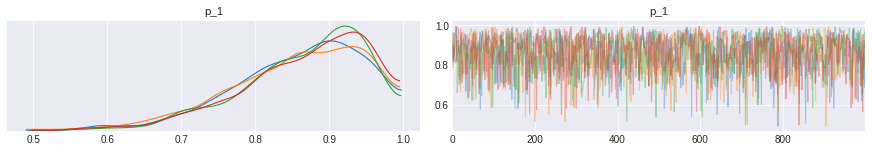

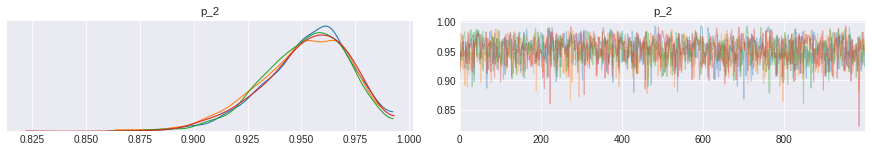

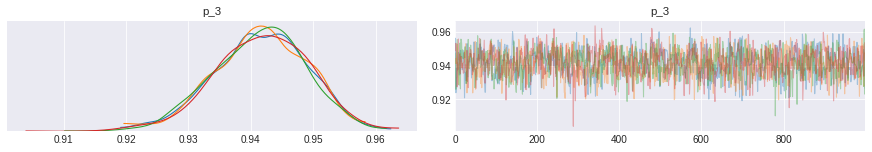

In [ ]:
with pm.Model() as review_1:
  p_1 = pm.Beta('p_1', alpha=2, beta=2)
  y = pm.Binomial('y', n=n_1, p=p_1, observed=positive_1)
  trace_1 = pm.sample(chains=4)

with pm.Model() as review_2:
  p_2 = pm.Beta('p_2', alpha=2, beta=2)
  y = pm.Binomial('y', n=n_2, p=p_2, observed=positive_2)
  trace_2 = pm.sample(chains=4)

with pm.Model() as review_3:
  p_3 = pm.Beta('p_3', alpha=2, beta=2)
  y = pm.Binomial('y', n=n_3, p=p_3, observed=positive_3)
  trace_3 = pm.sample(chains=4)

az.plot_trace(trace_1);
az.plot_trace(trace_2);
az.plot_trace(trace_3);

In [ ]:
p1_summary = pm.summary(trace_1, round_to=3, credible_interval=0.89)
p2_summary = pm.summary(trace_2, round_to=3, credible_interval=0.89)
p3_summary = pm.summary(trace_3, round_to=3, credible_interval=0.89)
pd.concat([p1_summary, p2_summary, p3_summary])

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p_1,0.858,0.089,0.737,0.988,0.002,0.002,1714.425,1632.428,1522.622,1998.930,1.001
p_2,0.952,0.020,0.922,0.983,0.000,0.000,1673.917,1662.500,1565.654,1804.648,1.003
p_3,0.942,0.007,0.930,0.954,0.000,0.000,1563.584,1562.330,1563.621,2578.876,1.000


Based on table above, we could see that seller #1 has lower mean and wider interval compared to seller #2 and seller #3. As we have the parameter distribution, we could calculate the probability that buying from seller #2 would have better experience than seller #1.

In [ ]:
np.mean(trace_2['p_2'] > trace_1['p_1'])

0.85975

So, there's a good chance that you would have better experience from buying from seller #2 rather than seller #1. 

To conclude, if we only have a relatively small data, we would have a lot of uncertainty around the positive rate, hence the average positive reviews could be misleading. But if we have a lot of reviews, using average of positive reviews would be sufficient.